### CNN 2nd Version
- Added random augmentation
- Swith to images with annotation
- Added regularization (L1, L2, dropout) to improve generalization
- Added batch normalization to stable training
- Start with 3 distinct classes, use the same architecture for 10-class

In [32]:
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
import keras_tuner as kt

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [33]:
with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())

# load data for 10 subclasses
X_train = data['X_train_bbox'] 
y_train = data['y_train_bbox']
X_val = data['X_val_bbox']
y_val = data['y_val_bbox']
X_test = data['X_test_bbox']
y_test = data['y_test_bbox']

# Filter sub classes
# breed = ['maltese_dog', 'afghan_hound', 'pomeranian'] # 3 classes
breed = ['maltese_dog', 'afghan_hound', 'pomeranian', 'samoyed','bernese_mountain_dog','basenji','leonberg','airedale','pug','beagle']  # 10 classes

train_mask = np.isin(y_train, breed)
val_mask = np.isin(y_val, breed)
test_mask = np.isin(y_test, breed)
num_breeds = len(breed)

X_train = X_train[train_mask]
y_train = y_train[train_mask]

X_val = X_val[val_mask]
y_val = y_val[val_mask]

X_test = X_test[test_mask]
y_test = y_test[test_mask]

# breed = data['classes_sub_bbox']
breed_ids = [i for i in range(len(breed))]
breed_id_map = {breed[i]:i for i in range(len(breed))}
id_breed_map = {id: label for label, id in breed_id_map.items()}
y_train = np.array([breed_id_map[x] for x in y_train])
y_val = np.array([breed_id_map[x] for x in y_val])
y_test = np.array([breed_id_map[x] for x in y_test])

print(breed)

dict_keys(['X_train_bbox', 'y_train_bbox', 'X_val_bbox', 'y_val_bbox', 'X_test_bbox', 'y_test_bbox', 'classes_bbox'])
['maltese_dog', 'afghan_hound', 'pomeranian', 'samoyed', 'bernese_mountain_dog', 'basenji', 'leonberg', 'airedale', 'pug', 'beagle']


In [ ]:
# Count the occurance of each breed in validation set
from collections import Counter
Counter(y_val)

In [34]:
# Check class balance
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
unique_elements, counts = np.unique(y_train, return_counts=True)
unique_elements_val, counts_val = np.unique(y_val, return_counts=True)

print(f"Check class balance in train: {counts}")
print(f"Check class balance in val: {counts_val}")

X_train shape: (1000, 64, 64, 3)
X_val shape: (582, 64, 64, 3)
Check class balance in train: [100 100 100 100 100 100 100 100 100 100]
Check class balance in val: [76 69 60 59 59 55 55 51 50 48]


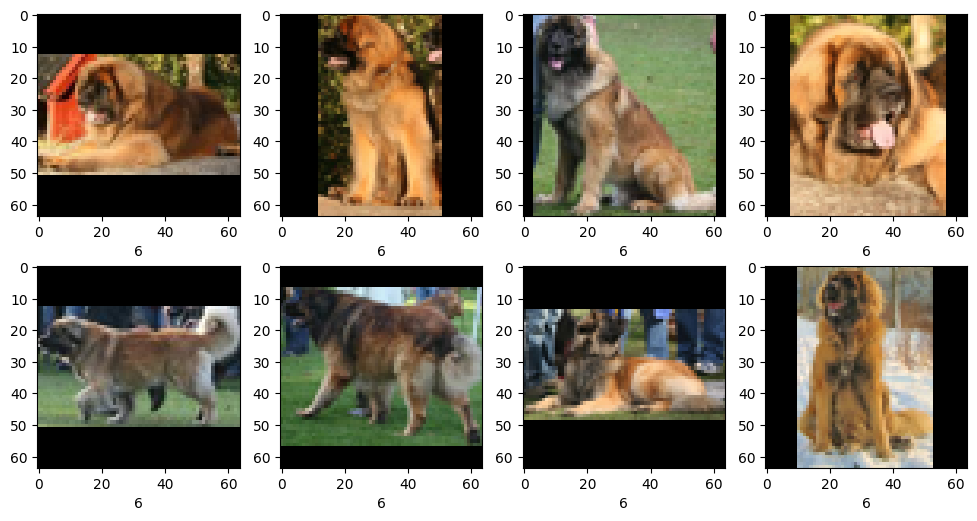

In [16]:
cols = 4
ind = [i for i, val in enumerate(y_train) if val == breed_id_map['leonberg']]
plt.figure(figsize=(cols * 3, 6)) 
for i in range(8):
    plt.subplot(2, cols, i + 1)
    plt.grid(False)
    img = array_to_img(X_train[ind[i]])
    plt.imshow(img)
    plt.xlabel(y_train[ind[i]])
plt.show()

In [35]:
def plot_acc_loss(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Plot Train Loss
    axes[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Validation Loss
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:orange')
    axes[1].set_title("Accuracy")  
    axes[1].set_xlabel("Epoch")
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle("Loss in CNN", fontsize=12)
    plt.tight_layout()
    plt.show()

Transformation and augmentation
- flip left and right - Dog images are usually symmetric, so flipping is safe
- Random rotation (0.5)
- random room in - Adds robustness to zoom
- Color and Lighting - ColorJitter(brightness=0.2, contrast=0.2)

### Build CNN and tune it manually

In [36]:
# initialize model
class ManualCNN(tf.keras.Model):
    def __init__(self, num_classes=num_breeds):
        super().__init__()

        self.preproc = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.5),
                tf.keras.layers.RandomZoom(0.2),
                # tf.keras.layers.RandomCrop(64, 64),  #<----- removed this as we are using annotation to define the boundaries
                tf.keras.layers.RandomBrightness(0.2, (0.0, 1.0)),
                tf.keras.layers.RandomContrast(0.2)
            ])

        self.L1 = 0.01
        self.L2 = 0.01
        self.max_pool = 2
        self.activation = 'relu'

        self.conv1 = tf.keras.layers.Conv2D(8, (8, 8), activation= self.activation, padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(self.L1, self.L2))
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=self.max_pool, strides=(2, 2), padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(16, (4, 4), activation = self.activation, padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(self.L1, self.L2))
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=self.max_pool, strides=(2, 2), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(16, (2, 2), activation=self.activation, padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(self.L1, self.L2))
        self.conv4 = tf.keras.layers.Conv2D(16, (2, 2), activation=self.activation, padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(self.L1, self.L2))
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=self.max_pool, strides=(2, 2), padding='same')

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation=self.activation)
        # self.dropout = tf.keras.layers.Dropout(0.25)
        self.fc2 = tf.keras.layers.Dense(128, activation=self.activation)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.out = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        if training:
            x = tf.keras.layers.Lambda(lambda t: self.preproc(t, training=True))(inputs)
        else:
            x = inputs
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        # x = self.dropout(x, training=training)
        x = self.fc2(x)
        x = self.dropout(x, training=training)
        return self.out(x)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.1182 - loss: 6.7133 - val_accuracy: 0.1546 - val_loss: 5.6309
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2038 - loss: 5.1890 - val_accuracy: 0.1478 - val_loss: 4.4766
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2502 - loss: 4.0717 - val_accuracy: 0.1426 - val_loss: 3.7402
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2683 - loss: 3.3669 - val_accuracy: 0.1031 - val_loss: 3.3343
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2314 - loss: 2.9663 - val_accuracy: 0.1838 - val_loss: 2.9310
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2637 - loss: 2.6463 - val_accuracy: 0.1237 - val_loss: 2.8755
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2829 - loss: 2.5471 - val_accuracy: 0.1701 - val_loss: 2.6298
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2774 - loss: 2.3555 - val_accuracy: 0.

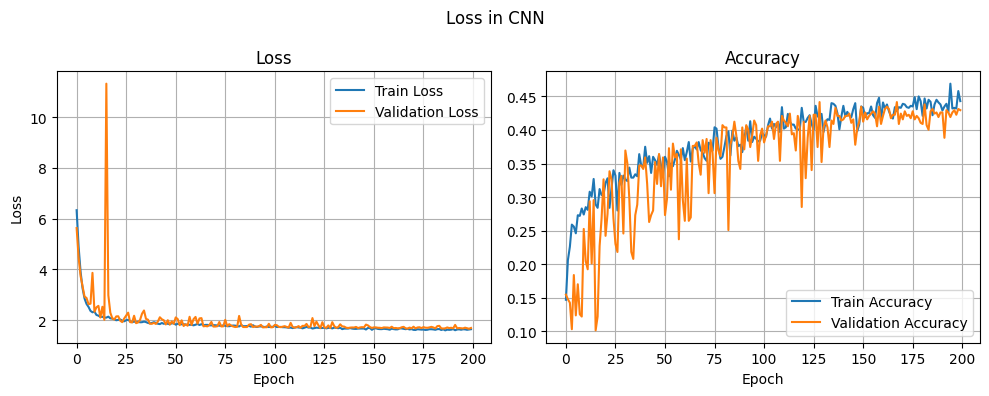

In [37]:
tf.keras.backend.clear_session()
model = ManualCNN(num_classes=num_breeds)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.8
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    verbose=1
)

plot_acc_loss(history)

#### Model Evaluation

In [43]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)
predicted_labels = [np.argmax(predicted[i]) for i in range(predicted.shape[0])]
predicted_names = [id_breed_map[i] for i in predicted_labels]
y_test_names = [id_breed_map[i] for i in y_test]
report  = classification_report(y_test_names, predicted_names, output_dict=True)
print(classification_report(y_test_names, predicted_names))


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
                      precision    recall  f1-score   support

        afghan_hound       0.39      0.16      0.22        70
            airedale       0.48      0.39      0.43        51
             basenji       0.19      0.19      0.19        54
              beagle       0.25      0.32      0.28        47
bernese_mountain_dog       0.55      0.88      0.68        59
            leonberg       0.36      0.64      0.46        55
         maltese_dog       0.65      0.34      0.45        76
          pomeranian       0.50      0.58      0.54        59
                 pug       0.33      0.20      0.25        50
             samoyed       0.56      0.66      0.60        59

            accuracy                           0.43       580
           macro avg       0.43      0.44      0.41       580
        weighted avg       0.44      0.43      0.41       580



In [39]:
# Evaluate test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4114 - loss: 1.7041
Test Loss: 1.6479, Test Accuracy: 0.4345


#### Subgroup Analysis

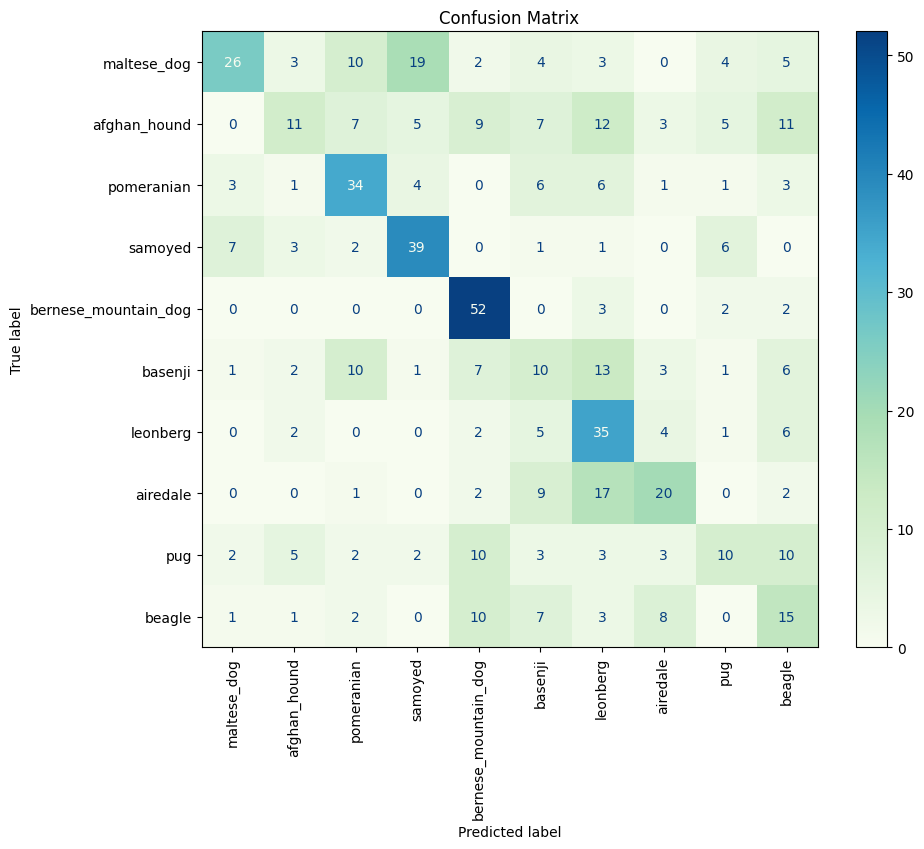

In [42]:
# plot confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=breed)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='GnBu', ax=ax, xticks_rotation=90)
plt.title('Confusion Matrix')
plt.show()

In [44]:
filtered_report = {k: v for k, v in report.items() if isinstance(v, dict)}
report_df = pd.DataFrame.from_dict(filtered_report, orient='index').sort_values(by='f1-score',ascending=False)
report_df.head(20)

,precision,recall,f1-score,support
bernese_mountain_dog,0.553191,0.881356,0.679739,59.0
samoyed,0.557143,0.661017,0.604651,59.0
pomeranian,0.500000,0.576271,0.535433,59.0
leonberg,0.364583,0.636364,0.463576,55.0
maltese_dog,0.650000,0.342105,0.448276,76.0
airedale,0.476190,0.392157,0.430108,51.0
weighted avg,0.439739,0.434483,0.414571,580.0
macro avg,0.426961,0.435075,0.410533,580.0
beagle,0.250000,0.319149,0.280374,47.0
pug,0.333333,0.200000,0.250000,50.0


In [30]:
mistakes = cm.sum(axis=1) - np.diag(cm)
mistake_df = pd.DataFrame(mistakes, columns=['mistakes'], index = breed).sort_values(by=['mistakes'], ascending=False)
mistake_df['total'] = cm.sum(axis=1)
mistake_df['error_rate'] = round(mistake_df['mistakes']/mistake_df['total'],2)
mistake_df

,mistakes,total,error_rate
afghan_hound,51,76,0.67
maltese_dog,46,69,0.67
pug,39,60,0.65
basenji,35,59,0.59
beagle,33,59,0.56
pomeranian,30,55,0.55
airedale,29,55,0.53
leonberg,23,51,0.45
samoyed,21,50,0.42
bernese_mountain_dog,16,48,0.33
